# S-2 image processing for NDVI retrieval

In [1]:
import ee
import time
#import geemap
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AfgeXvubXsimkzBUF68TweXe5zr3BOpr2hp8eNCEADI5__JzQe8ffuw1pj4



Successfully saved authorization token.


In [2]:
def timeseries(dates, data):
    """Returns a matrix (list of type(dates,data)) in the format [dates,data]"""
    
    if len(dates)==len(data):
        return [[dates[i],data[i]] for i in range(len(dates))]
    else: raise ValueError(
        f'dates and data must have same first dimension, but have shapes {np.shape(dates)} and {np.shape(data)}')


In [29]:
# Define area of interest
# If you have a GeoJSON file, copy paste.
# If you have a KML, export to GeoJSON (plenty of free tools online)
# or retrieve P

geoJSON = {
    "type": "FeatureCollection",
    "name": "Budrio_half-right",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": [
        { "type": "Feature", "properties": { "Name": "Budrio_campo_right", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.533083525108189, 44.570697786985733 ], [ 11.532456431504921, 44.569896556005418 ], [ 11.53276321111148, 44.569791821233608 ], [ 11.53338591526418, 44.570601794304793 ], [ 11.533083525108189, 44.570697786985733 ] ] ] } },
        { "type": "Feature", "properties": { "Name": "Budrio_campo_safe_half", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.53262979564736, 44.570842547510622 ], [ 11.532328100248961, 44.570445732016537 ], [ 11.53264162483709, 44.570339694294631 ], [ 11.532950828277439, 44.570738040751841 ], [ 11.53262979564736, 44.570842547510622 ] ] ] } }
    ]
}
coords = [geoJSON['features'][i]['geometry']['coordinates'] for i in range(2)]
aoi = ee.Geometry.MultiPolygon(coords)

# Filters definition
sp17 = ee.Filter.date('2017-04-04', '2017-05-22')
su17 = ee.Filter.date('2017-05-22', '2017-09-15')
au17 = ee.Filter.date('2017-09-15', '2017-11-02')
tot17 = ee.Filter.date('2017-01-01', '2017-12-31')

# Get collection of images and filter
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filter(tot17)
        #.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',70))
        .select(['B8', 'B4'])
        .sort('system:time_start'))
clouds = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filter(tot17)
        .sort('system:time_start'))
s2 = s2.combine(clouds)

# acq_times = img.aggregate_array('system:time_start').getInfo()
# len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

# To get all bands and infos of img collection, use
# img.getInfo()

In [30]:
s2.first().getInfo()['bands']

[{'id': 'B8',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32632',
  'crs_transform': [10, 0, 600000, 0, -10, 5000040]},
 {'id': 'B4',
  'data_type': {'type': 'PixelType',
   'precision': 'int',
   'min': 0,
   'max': 65535},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32632',
  'crs_transform': [10, 0, 600000, 0, -10, 5000040]},
 {'id': 'probability',
  'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255},
  'dimensions': [10980, 10980],
  'crs': 'EPSG:32632',
  'crs_transform': [10, 0, 600000, 0, -10, 5000040]}]

In [31]:
# Extract data
geometry_title = input('Please provide a title for AoI geometry. (Default: Budrio_half-right)')
if not geometry_title: geometry_title='Budrio_half-right'

def maskS2clouds(image):
    qa = image.select('QA60') # 60 m spat res TO0 BIG!!!
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask) \
                .select("B.*") \
                .copyProperties(image, ["system:time_start"])

def maskCloudPerc(image):
    return image.updateMask(image.select('probability').lte(thr))

def addNDVI(image:ee.Image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def extract_data(image:ee.Image):
    """Ausiliary function to extract data from an Image
    
    Optimal implementation is to map this function
    on a whole ImageCollection via .map() and insert the
    return into a ee.FeatureCollection.
    
    Return
    ------
    ee.Feature
    
    """
    
    ndvi=image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    image=image.addBands(ndvi)
    
    mean = image.reduceRegion(**{ 
        'reducer': ee.Reducer.mean(),
        'geometry': aoi,
    })
        
    properties = {
        'Date': image.get('system:time_start'), # only way to get a timestr is an external operation
        'Geometry': geometry_title,
        'NDVI': mean.get('NDVI'),
    }
    return ee.Feature(None, properties)

#-----------------------------------------------------------------------------

Please provide a title for AoI geometry. (Default: Budrio_half-right) 


In [34]:
# Clouds filtering
thr=70
s2_filt = s2.map(maskCloudPerc)

# Add NDVI and extract data
data = ee.FeatureCollection(s2_filt.map(extract_data))
data_out = data.getInfo()
data_out_to_df = [e.get('properties') for e in data_out.get('features')]; data_out_to_df[0]

{'Date': 1493028680576,
 'Geometry': 'Budrio_half-right',
 'NDVI': 0.13335260473204108}

In [48]:
df = pd.DataFrame.from_dict(data_out_to_df)

def clean_date(date:int):
    return time.strftime('%x %H', time.localtime((date)/1000))

df.Date = df.Date.apply(lambda x : pd.Timestamp(pd.to_datetime(clean_date(x))))
df=df.groupby('Date',as_index=False).mean()
df['Data'] = df.Date.apply(lambda x : pd.Timestamp(x.date()))
df

,Date,NDVI,Data
0,2017-04-24 12:00:00,0.140260,2017-04-24
1,2017-05-04 12:00:00,NaN,2017-05-04
2,2017-05-14 12:00:00,0.116067,2017-05-14
3,2017-05-24 12:00:00,NaN,2017-05-24
4,2017-06-03 12:00:00,0.139262,2017-06-03
5,2017-06-13 12:00:00,0.191475,2017-06-13
6,2017-06-23 12:00:00,0.441107,2017-06-23
7,2017-07-03 12:00:00,0.460864,2017-07-03
8,2017-07-13 12:00:00,0.613227,2017-07-13
9,2017-07-23 12:00:00,0.572060,2017-07-23


# Merging with in-situ data

Ref: Building_Golden.ipynb

In [46]:
# Platinum_Budrio has 2 sheets, one for 2017, one for 2020

import datetime as dtt

database = pd.ExcelFile('..\\Data\\Platinum_Budrio.xlsx', engine='openpyxl')

data_1h_2017 = database.parse('2017_1h')
data_1h_2017['Ora'] = pd.to_datetime(data_1h_2017['Ora'].astype('str')).apply(lambda x: x.time())
data_1h_2017['BiOra'] = data_1h_2017['Ora'].apply(lambda x: 2*np.around(x.hour/2))
data_1h_2017['Data'] = pd.to_datetime(data_1h_2017['Data'].astype('str')).apply(lambda x: x.date())
data_1h_2017['Mese'] = data_1h_2017['Data'].apply(lambda x: x.month)
data_1h_2017['Date'] = data_1h_2017.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
data_1h_2017.Data = data_1h_2017.Data.apply(lambda x : pd.to_datetime(x))
data_1h_2017 = data_1h_2017.drop(['ID', 'Ora', '214Pb[cps]', 'BiOra', 'Mese'],axis=1)
data_1h_2017

,Data,SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],Date
0,2017-04-03,0.173254,0.0,0.0,17.4097,2017-04-03 11:00:00
1,2017-04-03,0.174514,0.0,0.0,19.1982,2017-04-03 12:00:00
2,2017-04-03,0.178998,0.0,0.0,20.9032,2017-04-03 13:00:00
3,2017-04-03,0.206764,0.0,0.0,21.8341,2017-04-03 14:00:00
4,2017-04-03,0.169945,0.0,0.0,22.3737,2017-04-03 15:00:00
...,...,...,...,...,...,...
5120,2017-11-02,0.139442,0.0,0.0,11.3791,2017-11-02 19:00:00
5121,2017-11-02,0.135318,0.0,0.0,10.9391,2017-11-02 20:00:00
5122,2017-11-02,0.149532,0.0,0.0,10.7549,2017-11-02 21:00:00
5123,2017-11-02,0.130251,0.0,0.0,11.1445,2017-11-02 22:00:00


,NDVI
Datetime,
2017-04-03 11:00:00,0.000000
2017-04-03 12:00:00,0.000484
2017-04-03 13:00:00,0.000967
2017-04-03 14:00:00,0.001449
2017-04-03 15:00:00,0.001931
...,...
2017-11-02 19:00:00,0.001233
2017-11-02 20:00:00,0.000925
2017-11-02 21:00:00,0.000617


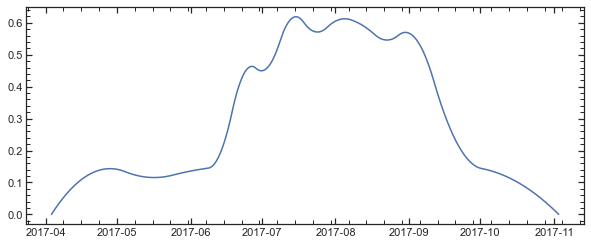

In [49]:
golden = pd.merge(left=df, right=data_1h_2017, how='right', on='Date'); golden

NDVI_tot = golden.NDVI.values
NDVI_tot[0] = 0; NDVI_tot[-1] = 0
golden.NDVI = NDVI_tot
NDVI_tot = golden.NDVI.interpolate(method='quadratic')
plt.figure(figsize=(10,4))
plt.plot(golden.Date, NDVI_tot, linestyle='-')

df_NDVI = pd.DataFrame(timeseries(golden.Date, NDVI_tot))\
    .rename(columns={0:'Datetime',1:'NDVI'}).set_index('Datetime'); df_NDVI

In [50]:
save = input("Wanna save in Data directory? [y/n] ")
if save=='y': df_NDVI.to_csv('..\\Data\\NDVI_GEE.csv', sep = '\t')

Wanna save in Data directory? [y/n]  y


# Snippets